In [1]:
import pandas as pd
import pickle
import numpy as np
%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [350]:
sv_df = pd.read_pickle("../dataset/dataframes/voxc1/sv_voxc_dataframe.pkl")
sv_df['num_idx'] = range(len(sv_df))

In [351]:
from sklearn.metrics import roc_curve, auc

def compute_eer(scores, labels):
    scores = np.array(scores)
    labels = np.array(labels)
    fpr, tpr, thres = roc_curve(
            labels, scores, pos_label=1)
    eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]
#     print(f"Postive trials: {sum(labels)}, Negative trials: {len(labels) - sum(labels)}")
#     print("EER: {:.3f}%".format(eer*100))
    return eer

## Scores

In [352]:
import torch
sv_dvector = pickle.load(open("../best_models/voxc1/ResNet34_v4_softmax/voxc_train_dvectors.pkl", "rb"))
dvectors = torch.from_numpy(np.stack([v for v in sv_dvector.values()], axis=0))

## Subsets

In [353]:
all_spks = sv_df.spk.unique()

### Subset trials

In [354]:
from torch.nn.functional import cosine_similarity

In [368]:
import torch
import itertools

def compute_eer_from_subset(subset_spks):
    subset_sv_df = sv_df[sv_df.spk.isin(subset_spks)].drop(columns=['set', 'feat', 'wav'])
#     subset_sv_df = subset_sv_df.groupby('spk', group_keys=False).apply(lambda x: x.sample(n=5))

    sub_dvectors = dict()
    for spk in subset_spks:
        sub_dvectors[spk] = dvectors[subset_sv_df[subset_sv_df.spk == spk].num_idx]

    score_vector = []
    label_vector = []
    for a, b in itertools.combinations_with_replacement(subset_spks, r=2):
        random.shuffle(sub_dvectors[a])
        random.shuffle(sub_dvectors[b])
        a_dvectors = torch.stack([t.mean(dim=0) for t in sub_dvectors[a].split(5, dim=0)], dim=0)
#         b_dvectors = sub_dvectors[b]
        b_dvectors = torch.stack([t.mean(dim=0) for t in sub_dvectors[b].split(1, dim=0)], dim=0)
        scores = cosine_similarity(a_dvectors.unsqueeze(1), b_dvectors.unsqueeze(0), dim=2)
        scores = scores.triu(diagonal=1).view(-1)
        scores = scores[scores.nonzero()].view(-1).tolist()
        score_vector += scores
        if a == b:
            label_vector += len(scores) * [1]
        else:
            label_vector += len(scores) * [0]

    eer = compute_eer(score_vector, label_vector)
    
    return eer

In [369]:
spks_stat = []
eer_stat = []
for _ in range(1000):
    subset_spks = np.random.choice(all_spks, size=4, replace=False)
    spks_stat.append(subset_spks)
    eer_stat.append(compute_eer_from_subset(subset_spks))

(array([256., 146., 120.,  84.,  94.,  72.,  62.,  40.,  40.,  27.,  13.,
         16.,   1.,   9.,   5.,   5.,   2.,   4.,   2.,   2.]),
 array([0.        , 0.01146123, 0.02292246, 0.03438369, 0.04584491,
        0.05730614, 0.06876737, 0.0802286 , 0.09168983, 0.10315106,
        0.11461228, 0.12607351, 0.13753474, 0.14899597, 0.1604572 ,
        0.17191843, 0.18337966, 0.19484088, 0.20630211, 0.21776334,
        0.22922457]),
 <a list of 20 Patch objects>)

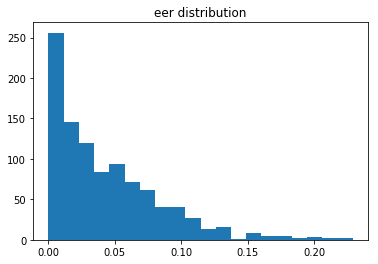

In [373]:
plt.title("eer distribution")
plt.hist(eer_stat, bins=20)

In [193]:
sort_result = np.argsort(eer_stat)

In [213]:
hard_imposters = []
for idx in sort_result[-30:]:
    hard_imposters += [spks_stat[idx]]

In [372]:
hard_imposters

[array(['Shahid_Kapoor', 'Costas_Mandylor', 'Lolo_Jones', 'Tamer_Hassan'],
       dtype=object),
 array(['Mark_Hamill', 'Jean-Marc_Barr', 'Harry_Connick_Jr.',
        'Antonio_Cupo'], dtype=object),
 array(['Jennifer_Carpenter', 'Stephen_Mangan', 'Neve_Campbell',
        'Alison_Pill'], dtype=object),
 array(['Odette_Annable', 'Jake_T._Austin', 'Hayley_Marie_Norman',
        'Reece_Ritchie'], dtype=object),
 array(['Caity_Lotz', 'Nicki_Minaj', 'Danielle_Campbell', 'Nicole_Richie'],
       dtype=object),
 array(['Vanessa_Hudgens', 'Damon_Wayans', 'David_Mazouz', 'A.R._Rahman'],
       dtype=object),
 array(['Diogo_Morgado', 'Ralf_Little', 'James_Nesbitt', 'Will_Arnett'],
       dtype=object),
 array(['Stevie_Wonder', 'Peter_Jacobson', 'T.J._Miller', 'Daniel_Tosh'],
       dtype=object),
 array(['Niall_Horan', 'Noel_Clarke', 'Jon_Pertwee', 'A.J._Buckley'],
       dtype=object),
 array(['Richard_Dean_Anderson', 'Justine_Ezarik', 'Charles_Dance',
        'Maggie_Gyllenhaal'], dtype=object)

In [339]:
compute_eer_from_subset(np.array(['Thomas_Ian_Nicholas', 'Kodi_Smit-McPhee']))

0.007399577167019027

In [230]:
sv_df[sv_df.spk == 'Kodi_Smit-McPhee'].sample(n=5).wav

file
Kodi_Smit-McPhee/l2AtSczOwjg_0000008    Kodi_Smit-McPhee/l2AtSczOwjg_0000008.wav
Kodi_Smit-McPhee/Ngmd5dadQkc_0000009    Kodi_Smit-McPhee/Ngmd5dadQkc_0000009.wav
Kodi_Smit-McPhee/NUZdfoqhB8o_0000010    Kodi_Smit-McPhee/NUZdfoqhB8o_0000010.wav
Kodi_Smit-McPhee/vEUSKchOVHI_0000002    Kodi_Smit-McPhee/vEUSKchOVHI_0000002.wav
Kodi_Smit-McPhee/NUZdfoqhB8o_0000015    Kodi_Smit-McPhee/NUZdfoqhB8o_0000015.wav
Name: wav, dtype: object

In [285]:
sv_df[sv_df.spk == 'Thomas_Ian_Nicholas'].sample(n=5).wav

file
Thomas_Ian_Nicholas/pQMUErWp-CA_0000024    Thomas_Ian_Nicholas/pQMUErWp-CA_0000024.wav
Thomas_Ian_Nicholas/0qERIT_cLB4_0000003    Thomas_Ian_Nicholas/0qERIT_cLB4_0000003.wav
Thomas_Ian_Nicholas/pQMUErWp-CA_0000015    Thomas_Ian_Nicholas/pQMUErWp-CA_0000015.wav
Thomas_Ian_Nicholas/KzRZ2DoZTDY_0000001    Thomas_Ian_Nicholas/KzRZ2DoZTDY_0000001.wav
Thomas_Ian_Nicholas/ZLUG261s9R4_0000009    Thomas_Ian_Nicholas/ZLUG261s9R4_0000009.wav
Name: wav, dtype: object

In [160]:
from IPython.display import Audio

In [287]:
Audio("../dataset/voxceleb1/voxceleb1_wav/" + "Kodi_Smit-McPhee/Ngmd5dadQkc_0000009.wav")

In [289]:
Audio("../dataset/voxceleb1/voxceleb1_wav/" + "Thomas_Ian_Nicholas/KzRZ2DoZTDY_0000001.wav")

## Find out great experiment setup

In [371]:
sv_df

,set,spk,feat,wav,num_idx
,,,,,
Eartha_Kitt/5r0dWxy17C8_0000001,1,Eartha_Kitt,Eartha_Kitt/5r0dWxy17C8_0000001.npy,Eartha_Kitt/5r0dWxy17C8_0000001.wav,0
Eartha_Kitt/5r0dWxy17C8_0000002,1,Eartha_Kitt,Eartha_Kitt/5r0dWxy17C8_0000002.npy,Eartha_Kitt/5r0dWxy17C8_0000002.wav,1
Eartha_Kitt/5r0dWxy17C8_0000003,1,Eartha_Kitt,Eartha_Kitt/5r0dWxy17C8_0000003.npy,Eartha_Kitt/5r0dWxy17C8_0000003.wav,2
Eartha_Kitt/5r0dWxy17C8_0000004,1,Eartha_Kitt,Eartha_Kitt/5r0dWxy17C8_0000004.npy,Eartha_Kitt/5r0dWxy17C8_0000004.wav,3
Eartha_Kitt/5r0dWxy17C8_0000005,1,Eartha_Kitt,Eartha_Kitt/5r0dWxy17C8_0000005.npy,Eartha_Kitt/5r0dWxy17C8_0000005.wav,4
Eartha_Kitt/5r0dWxy17C8_0000006,1,Eartha_Kitt,Eartha_Kitt/5r0dWxy17C8_0000006.npy,Eartha_Kitt/5r0dWxy17C8_0000006.wav,5
Eartha_Kitt/5r0dWxy17C8_0000007,1,Eartha_Kitt,Eartha_Kitt/5r0dWxy17C8_0000007.npy,Eartha_Kitt/5r0dWxy17C8_0000007.wav,6
Eartha_Kitt/5r0dWxy17C8_0000008,1,Eartha_Kitt,Eartha_Kitt/5r0dWxy17C8_0000008.npy,Eartha_Kitt/5r0dWxy17C8_0000008.wav,7
Eartha_Kitt/5r0dWxy17C8_0000009,1,Eartha_Kitt,Eartha_Kitt/5r0dWxy17C8_0000009.npy,Eartha_Kitt/5r0dWxy17C8_0000009.wav,8
